In [2]:
import subprocess
import os
import math
from functions.basefunctions import *
from collections import defaultdict
import numpy as np
import time 

kbT_RNA = 0.6163207755

In [6]:
def suboptfolding(seq, energy_range=9.2448116325):
    # suboptimals and their energies
    rnasubopt_path = os.path.expanduser("~/ViennaRNA/bin/RNAsubopt")
    
    if not os.path.isfile(rnasubopt_path):
        raise FileNotFoundError(f"RNAfold not found at {rnasubopt_path}")
    
    rnasubopt = subprocess.Popen(
        [rnasubopt_path, "-e", str(energy_range)],
        stdin=subprocess.PIPE,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        env={"PATH": os.environ["PATH"]}
    )
    
    stdout, stderr = rnasubopt.communicate(input=bytes(seq, 'UTF-8'))
    
    if rnasubopt.returncode != 0:
        raise RuntimeError(f"RNAfold failed with error: {stderr.decode()}")
    
    output = stdout.decode().strip().split('\n')    
    
    if not os.path.isfile(rnasubopt_path):
        raise FileNotFoundError(f"RNAfold not found at {rnasubopt_path}")
    
    #ensemble free energy

    rnasubopt_path = os.path.expanduser("~/ViennaRNA/bin/RNAfold")

    rnasubopt = subprocess.Popen(
        [rnasubopt_path, "-p"],
        stdin=subprocess.PIPE,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        env={"PATH": os.environ["PATH"]}
    )
    
    stdout, stderr = rnasubopt.communicate(input=bytes(seq, 'UTF-8'))
    
    if rnasubopt.returncode != 0:
        raise RuntimeError(f"RNAfold failed with error: {stderr.decode()}")
    
    outputF = stdout.decode().strip().split('\n')
    Fens = float(outputF[2].replace('[','').replace(']','').strip().split()[1])

    # Extract the fold, energy and Boltzmann probabilities
    subopts = []
    folds = []
    probs = []
    energies = []
    if len(output) >= 2:
        for i in range(2, len(output)):
            foldandenergy = output[i].split()
            fold = (foldandenergy[0])
            folds.append(fold)
            energy = float(foldandenergy[1])
            energies.append(energy)
            prob = math.exp(Fens - energy) / kbT_RNA
            probs.append(prob)
            
    else:
        raise RuntimeError("Unexpected RNAfold output format")
    
    probs = normalize(probs)
    for f,e,p in zip(folds,energies,probs):
        subopts.append((f,e,p))

    subopts = sorted(subopts, key=lambda x: x[1])
    return subopts



In [3]:

def read_fasta(file_path):
    sequences = {}
    with open(file_path) as f:
        seqname = ''
        seq = ''
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                if seqname:
                    sequences[seqname] = seq
                seqname = line.lstrip('>')
                seq = ''
            else:
                seq += line
        if seqname:
            sequences[seqname] = seq
    return sequences  

def filtersequences(sequences,L=50):
    filtered_sequences = {}
    for seqname, seq in sequences.items():
        if len(seq) <= L:
            filtered_sequences[seqname] = seq
    return filtered_sequences

In [7]:
if __name__ == "__main__":
    sequence = "GGGAAAUCC"
    energy_range = 9.2448116325
    output = suboptfolding(sequence, energy_range)
    print(output)
    
    sequences = read_fasta('../data/sequence.fasta')
    sequences = filtersequences(sequences)

    hammingdistance = defaultdict(float)
    prob2= defaultdict(float)
    folds = defaultdict(tuple)
    for seqname, seq in sequences.items():
        start = time.time()
        output = suboptfolding(seq, energy_range)
        print(output)
        print(len(output))
        folds[(seqname,seq)] = (output[0][0], output[1][0])
        hammingdistance[(seqname,seq)] = hamming(output[0][0], output[1][0])
        prob2[(seqname,seq)] = output[1][2]
        end = time.time()
        print(folds)
        print(hammingdistance)
        print(prob2)
        print(f"Time taken: {end-start} seconds")
        break

[('.........', 0.0, 0.39635502366105047), ('.((....))', 0.8, 0.17809379220427665), ('((.....))', 0.9, 0.16114592710635042), ('(((...)))', 1.1, 0.13193512625523182), ('((....)).', 2.3, 0.03973809637598145), ('(......).', 3.1, 0.017855477680610056), ('..(....).', 3.1, 0.017855477680610056), ('.(.....).', 3.2, 0.01615630432232191), ('.((...)).', 3.4, 0.013227663204771672), ('.(......)', 3.9, 0.008022983290046685), ('..(.....)', 4.2, 0.0059435722054915424), ('.(....)..', 4.4, 0.004866185347775451), ('(.(....))', 4.6, 0.003984095594401238), ('(.....)..', 5.1, 0.0024164761292303797), ('..(...)..', 5.7, 0.0013261902180650839), ('((....).)', 6.9, 0.00039944081757578435), ('(.(...).)', 7.1, 0.0003270344813839069), ('(.(...)).', 7.4, 0.00024227310260039413), ('.((...).)', 8.2, 0.00010886032222490054)]
[('..((((.....))))((((......)))).', -1.0, 0.061209979363734034), ('..((((.....))))...............', -0.7, 0.04534546800020611), ('...............((((......)))).', -0.3, 0.030395976197405774), ('..(

In [2]:
import pickle

with open('../data/fRNAhammingdistance.pkl', 'rb') as f:
    fRNAhammingdistance = pickle.load(f)

with open('../data/fRNAprob2.pkl', 'rb') as f:
    fRNAprob2 = pickle.load(f)

with open('../data/fRNAprob1.pkl', 'rb') as f:
    fRNAprob1 = pickle.load(f)

with open('../data/fRNAfolds.pkl', 'rb') as f:
    fRNAfolds = pickle.load(f)

In [2]:
len(fRNAhammingdistance), len(fRNAprob2)

(311016, 311016)

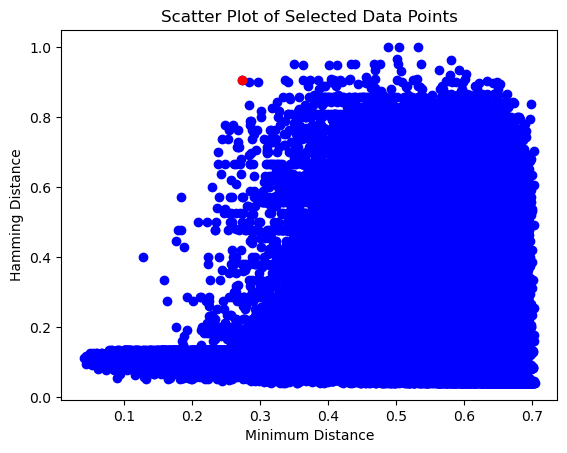

In [3]:
from matplotlib import pyplot as plt 
import numpy as np

# Calculate the distance from the diagonal (0.5, 0.5)
diagonal_distances = {}
for x, y,key1,key2 in zip(fRNAprob1.values(), fRNAprob2.values(), fRNAprob1.keys(), fRNAprob2.keys()):
    if key1 == key2:
        distance = np.sqrt((x - 0.5)**2 + (y - 0.5)**2)
        diagonal_distances[key1] = distance

# Normalize the Hamming distances and diagonal distances
#max_hamming = max(fRNAhammingdistance.values())
#min_diagonal_distance = min(diagonal_distances.values())

#normalized_hamming = {name: hamming / max_hamming for name, hamming in fRNAhammingdistance.items()}
#normalized_diagonal_distance = {name: distance / min_diagonal_distance for name, distance in diagonal_distances.items()}

#Calculate the combined score (maximize Hamming distance and minimize diagonal distance)
scores = {}
for name in fRNAhammingdistance.keys(): 
    scores[name] = fRNAhammingdistance[name] - diagonal_distances[name] 
# Remove entries from scores where the sequence of dots is in fRNAfolds
filtered_scores = {key: value for key, value in scores.items() if '.' * len(key[1]) not in fRNAfolds[key]}

# Select the data points with the highest scores
selected_data = sorted(filtered_scores.items(), key=lambda item: item[1], reverse=True)

# Extract the Hamming values and their corresponding minimum distances
selected_hamming_values = [fRNAhammingdistance[name] for name, score in selected_data]
selected_min_distances = [diagonal_distances[name] for name, score in selected_data]
selected_names = [name for name, score in selected_data]

# Create a scatter plot
plt.scatter(selected_min_distances, selected_hamming_values, c='blue', marker='o')
plt.scatter(selected_min_distances[0], selected_hamming_values[0], c='red', marker='o')

# Add labels and title
plt.ylabel('Hamming Distance')
plt.xlabel('Minimum Distance')
plt.title('Scatter Plot of Selected Data Points')

# Show the plot
plt.show()

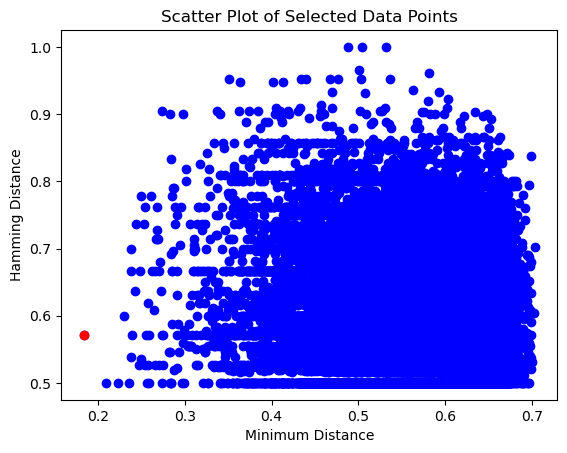

In [54]:
from matplotlib import pyplot as plt 
import numpy as np

# Calculate the distance from the diagonal (0.5, 0.5)
diagonal_distances = {}
for x, y,key1,key2 in zip(fRNAprob1.values(), fRNAprob2.values(), fRNAprob1.keys(), fRNAprob2.keys()):
    if key1 == key2:
        distance = np.sqrt((x - 0.5)**2 + (y - 0.5)**2)
        diagonal_distances[key1] = distance

# Normalize the Hamming distances and diagonal distances
#max_hamming = max(fRNAhammingdistance.values())
#min_diagonal_distance = min(diagonal_distances.values())

#normalized_hamming = {name: hamming / max_hamming for name, hamming in fRNAhammingdistance.items()}
#normalized_diagonal_distance = {name: distance / min_diagonal_distance for name, distance in diagonal_distances.items()}

#Calculate the combined score (maximize Hamming distance and minimize diagonal distance)
scores = {}
for name in fRNAhammingdistance.keys(): 
    scores[name] = diagonal_distances[name] 
# Remove entries from scores where the sequence of dots is in fRNAfolds
filtered_scores = {key: value for key, value in scores.items() if '.' * len(key[1]) not in fRNAfolds[key] and fRNAhammingdistance[key] >= 0.5}

# Select the data points with the highest scores
selected_data = sorted(filtered_scores.items(), key=lambda item: item[1])

# Extract the Hamming values and their corresponding minimum distances
selected_hamming_values = [fRNAhammingdistance[name] for name, score in selected_data]
selected_min_distances = [diagonal_distances[name] for name, score in selected_data]
selected_names = [name for name, score in selected_data]

# Create a scatter plot
plt.scatter(selected_min_distances, selected_hamming_values, c='blue', marker='o')
plt.scatter(selected_min_distances[0], selected_hamming_values[0], c='red', marker='o')

# Add labels and title
plt.ylabel('Hamming Distance')
plt.xlabel('Minimum Distance')
plt.title('Scatter Plot of Selected Data Points')

# Show the plot
plt.show()

In [31]:
p1 = fRNAprob1[selected_names[0]]
p2 = fRNAprob2[selected_names[0]]
print(p1,p2)

0.4403821543001153 0.3262431239685932


In [6]:
selected_names

[('FR456139||Fly small RNA', 'GCAGAGCTGCAGCGATGCGGA'),
 ('FR422481||Fly small RNA', 'AGTCAAACGGCAAAACGG'),
 ('FR432996||Fly small RNA', 'CACCCTGCCGGGCACACCGA'),
 ('FR232641||Putative conserved noncoding region (EvoFold)',
  'GCCGCTGCTGTGGCAGCTGC'),
 ('FR447805||Fly small RNA', 'CTGGAGCTGGAGCTGCAGCT'),
 ('FR015670|DQ600272|Piwi-interacting RNA (piRNA)',
  'TACCTACAAAAACAGGCAGTGGGCCA'),
 ('FR479604||Fly small RNA', 'TCCAGTGCTGGCTGAAGTAC'),
 ('FR438833||Fly small RNA', 'CCGGATCCACCGGAAGAGGTG'),
 ('FR490430||Fly small RNA', 'TGGAGCATTTGATTGCAAATG'),
 ('FR336157||Putative conserved noncoding region (EvoFold)',
  'GGTGAGAGGCACCACATTTACC'),
 ('FR416265||Fly small RNA', 'ACCAAGCGAGTTGGACGCG'),
 ('FR319871||Putative conserved noncoding region (EvoFold)',
  'CCTTTGTCTCAGAGGAAGG'),
 ('FR423017||Fly small RNA', 'AGTGGTATGCCACAGAAGGCA'),
 ('FR454945||Fly small RNA', 'GATGGTCTCATCGACGGT'),
 ('FR124323|DQ699141|Piwi-interacting RNA (piRNA)',
  'TCTCCAATTACGGAGAACCAATCTCCAG'),
 ('FR438883||Fly small R

In [10]:
import pickle
with open('../data/site_scanning_probs_pval_0.pkl', 'rb') as f:
    site_scanning_probs_pval_0 = pickle.load(f)

In [35]:
site_scanning_probs_pval_0['p_value']

0.4340956590434096

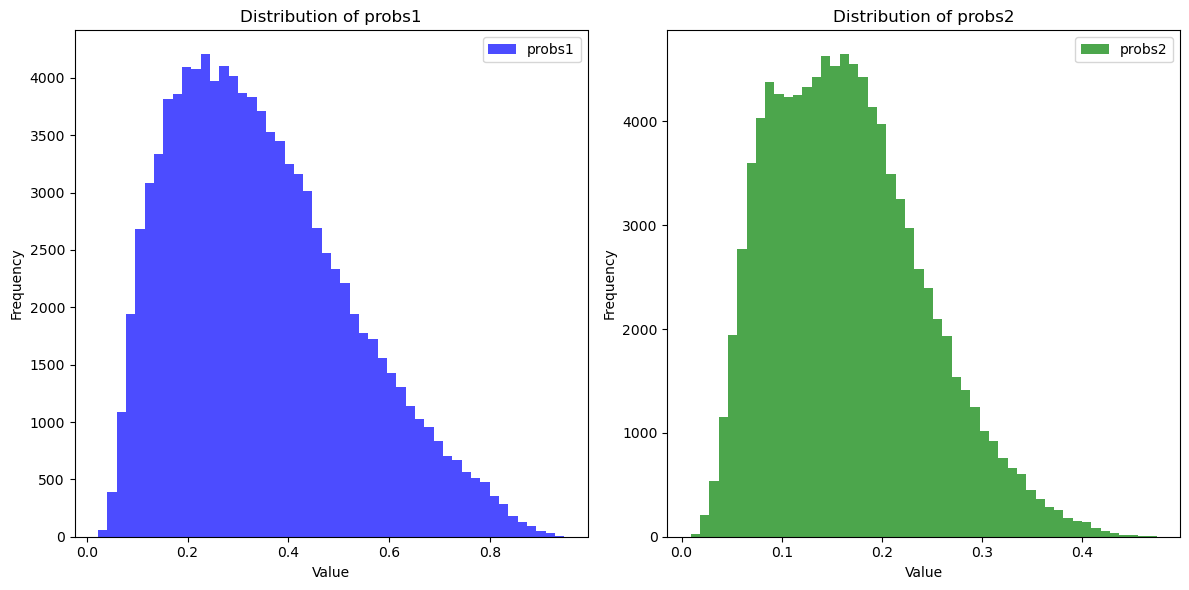

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Assuming site_scanning_probs_pval_0 is already defined as a dictionary
# site_scanning_probs_pval_0 = {...}

# Extract probs1 and probs2 from the dictionary
probs1 = np.array(site_scanning_probs_pval_0['probs1'])
probs2 = np.array(site_scanning_probs_pval_0['probs2'])

# Plot the distributions
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(probs1, bins=50, alpha=0.7, color='blue', label='probs1')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of probs1')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(probs2, bins=50, alpha=0.7, color='green', label='probs2')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of probs2')
plt.legend()

plt.tight_layout()
plt.show()

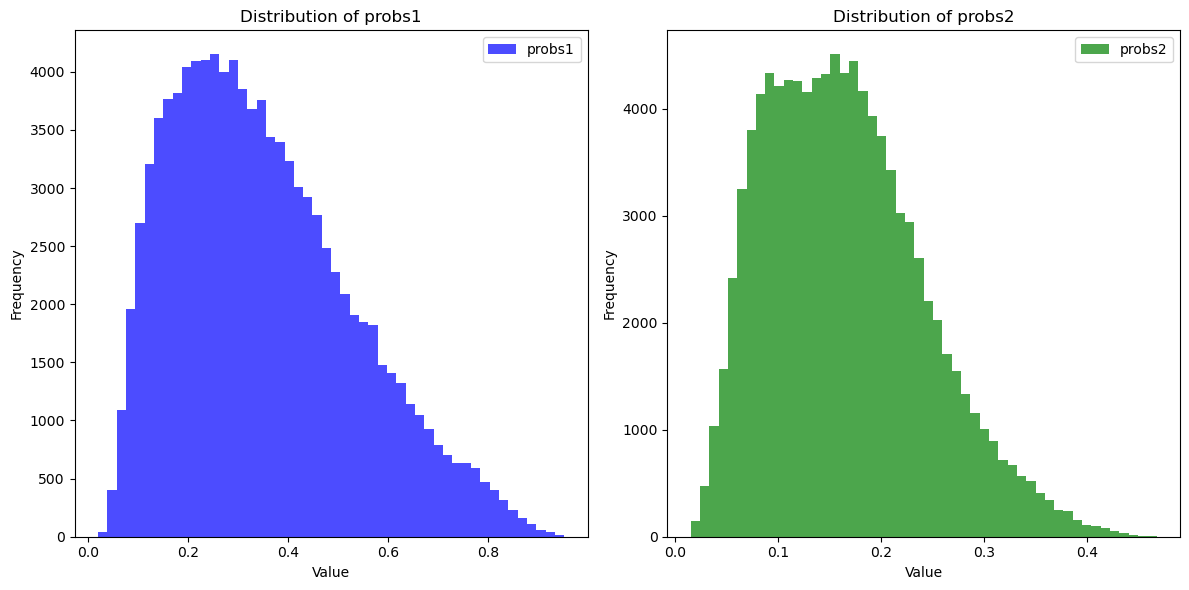

In [ ]:
probs1 = site_scanning_probs_pval_seq0_ssize100000['probs1']
probs2 = site_scanning_probs_pval_seq0_ssize100000['probs2']
# Plot the distributions
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(probs1, bins=50, alpha=0.7, color='blue', label='probs1')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of probs1')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(probs2, bins=50, alpha=0.7, color='green', label='probs2')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of probs2')
plt.legend()

plt.tight_layout()
plt.show()

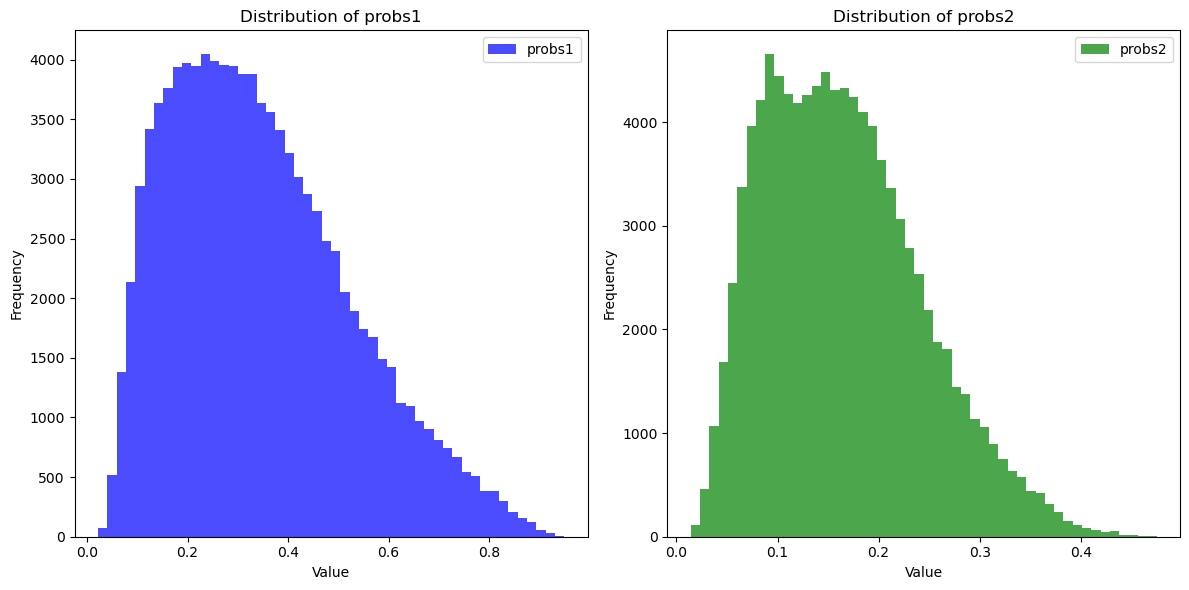

In [46]:
with open('../data/site_scanning_probs_pval_seq16_ssize100000.pkl', 'rb') as f:
    site_scanning_probs_pval_seq16_ssize100000 = pickle.load(f)
probs1 = site_scanning_probs_pval_seq16_ssize100000['probs1']
probs2 = site_scanning_probs_pval_seq16_ssize100000['probs2']
# Plot the distributions
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(probs1, bins=50, alpha=0.7, color='blue', label='probs1')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of probs1')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(probs2, bins=50, alpha=0.7, color='green', label='probs2')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of probs2')
plt.legend()

plt.tight_layout()
plt.show()

In [47]:
p1 = fRNAprob1[selected_names[16]]
p2 = fRNAprob2[selected_names[16]]
print(p1,p2)

0.32042381176631124 0.32042381176631124


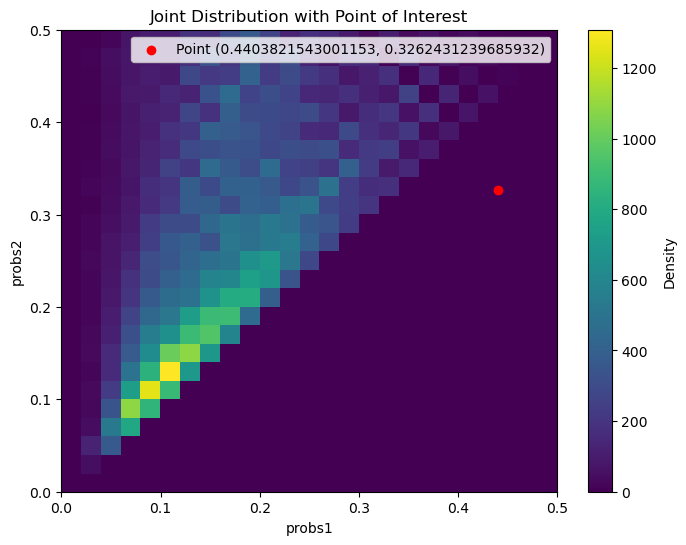

In [36]:
plt.figure(figsize=(8, 6))
density, xedges, yedges = np.histogram2d(probs1, probs2, bins=50, range=[[0, 1], [0, 1]])
plt.imshow(density, origin='lower', extent=[0, 1, 0, 1], aspect='auto', cmap='viridis')
plt.xlim(0.0, 0.5)
plt.ylim(0.0, 0.5)

plt.colorbar(label='Density')
plt.scatter(p1, p2, color='red', label=f'Point ({p1}, {p2})')
plt.xlabel('probs1')
plt.ylabel('probs2')
plt.title('Joint Distribution with Point of Interest')
plt.legend()
plt.show()

In [24]:
with open('../data/site_scanning_probs_pval_seq0_ssize1000.pkl', 'rb') as f:
    site_scanning_probs_pval_seq0_ssize1000 = pickle.load(f)

In [37]:
probs2 = site_scanning_probs_pval_seq0_ssize100000['probs2']

0.15958840411595884

In [55]:
import numpy as np
from scipy.stats import norm

# Load your data (probs1)
np.random.seed(42)
probs2 = site_scanning_probs_pval_seq16_ssize100000['probs2'] # Replace with your actual data

# Example observed value
observed_value = fRNAprob2[selected_names[16]]  # Replace with your specific value

# Calculate the mean and standard deviation of the data
mean = np.mean(probs2)
std_dev = np.std(probs2)

# Compute the z-score for the observed value
z_score = (observed_value - mean) / std_dev

# One-tailed p-value (upper-tail)
p_value_upper = 1 - norm.cdf(z_score)

# One-tailed p-value (lower-tail)
p_value_lower = norm.cdf(z_score)

# Two-tailed p-value
#p_value_two_tailed = 2 * min(p_value_upper, p_value_lower)

# Print results
print(f"Observed value: {observed_value}")
print(f"Mean: {mean}, Standard Deviation: {std_dev}")
print(f"Z-Score: {z_score}")
print(f"One-tailed p-value (upper-tail): {p_value_upper}")
#print(f"One-tailed p-value (lower-tail): {p_value_lower}")
#print(f"Two-tailed p-value: {p_value_two_tailed}")


Observed value: 0.32042381176631124
Mean: 0.16477040076025318, Standard Deviation: 0.0770644130991356
Z-Score: 2.0197832533393285
One-tailed p-value (upper-tail): 0.021702937485844398


In [115]:
import glob
import pandas as pd
import re
import numpy as np
from scipy.stats import norm
from collections import defaultdict
# Path to the data folder
data_folder = '../data/'

# Pattern to match the files
file_pattern = data_folder + 'site_scanning_probs_pval_seq*_ssize100000.pkl'

# List to store p-values from all files
nameandrankdist_hammingandprobs_pvals = defaultdict(dict)

# Assuming fRNAprob2 and selected_names are defined
# Example:
# fRNAprob2 = {'name1': value1, 'name2': value2, ...}
# selected_names = {0: 'name1', 1: 'name2', ...}

# Find all files matching the pattern
files = glob.glob(file_pattern)

# Loop through each file and extract probs2
for file in files:
    match = re.search(r'site_scanning_probs_pval_seq(\d+)_ssize100000', file)
    
    if match:
        seq_number = int(match.group(1))
        print(seq_number)
        # Read the file into a DataFrame
        with open(file, 'rb') as f:
            data = pickle.load(f)
        
        # Extract probs2 and append to the list
        probs2 = list(data['probs2'])
        observed_value = fRNAprob2[selected_names[seq_number]]  # Replace with your specific value
        
        mean = np.mean(probs2)
        std_dev = np.std(probs2)

        # Compute the z-score for the observed value
        z_score = (observed_value - mean) / std_dev

        # One-tailed p-value (upper-tail)
        p_value_upper = 1 - norm.cdf(z_score)
        if p_value_upper < 0.05:
            nameandrankdist_hammingandprobs_pvals[(selected_names[seq_number],seq_number)][(fRNAhammingdistance[selected_names[seq_number]],fRNAprob1[selected_names[seq_number]],fRNAprob2[selected_names[seq_number]])] = p_value_upper
    


24
19
6
8
26
22
4
0
13
2
21
11
20
23
1
27
7
17
12
3
9
15
16
25
5
18


In [116]:
nameandrankdist_hammingandprobs_pvals.keys()

dict_keys([(('FR490430||Fly small RNA', 'TGGAGCATTTGATTGCAAATG'), 8), (('FR456139||Fly small RNA', 'GCAGAGCTGCAGCGATGCGGA'), 0), (('FR454945||Fly small RNA', 'GATGGTCTCATCGACGGT'), 13), (('FR319871||Putative conserved noncoding region (EvoFold)', 'CCTTTGTCTCAGAGGAAGG'), 11), (('FR422481||Fly small RNA', 'AGTCAAACGGCAAAACGG'), 1), (('FR132646|DQ703740|Piwi-interacting RNA (piRNA)', 'CTATCCAACCCAGATGGG'), 27), (('FR423017||Fly small RNA', 'AGTGGTATGCCACAGAAGGCA'), 12), (('FR336157||Putative conserved noncoding region (EvoFold)', 'GGTGAGAGGCACCACATTTACC'), 9), (('FR412251||Fly small RNA', 'AAGGAGCATCGTCCACCGGTG'), 16), (('FR446582||Fly small RNA', 'CTCTTTAGCTCAGTGGAGAGCACT'), 25)])

In [117]:
siglengthRNA = []
sighammingRNA = []
sigdistRNA = []
for name in nameandrankdist_hammingandprobs_pvals.keys():
    siglengthRNA.append(lengthRNA[name[1]])
    sighammingRNA.append(selected_hamming_values[name[1]])
    sigdistRNA.append(selected_min_distances[name[1]])

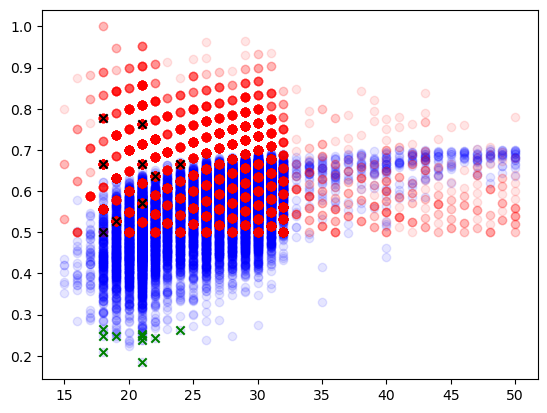

In [118]:
plt.scatter(lengthRNA, selected_min_distances, c='blue', marker='o',alpha=0.1)
plt.scatter(lengthRNA, selected_hamming_values, c='red', marker='o', alpha=0.1)
plt.scatter(siglengthRNA, sighammingRNA, c='black', marker='x', alpha=1.0)
plt.scatter(siglengthRNA, sigdistRNA, c='green', marker='x', alpha=1.0)

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for demonstration

# Combine the data into a 2D array
data = np.vstack([lengthRNA, selected_min_distances, selected_hamming_values]).T

# Create a 2D histogram
heatmap, xedges, yedges = np.histogram2d(lengthRNA, selected_min_distances, bins=(len(np.unique(lengthRNA)), len(np.unique(selected_min_distances))))

# Plotting
plt.figure(figsize=(10, 6))

# Display the heatmap
plt.imshow(heatmap.T, origin='lower', aspect='auto', cmap='viridis', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

# Add colorbar
plt.colorbar(label='Density')

# Set x and y ticks
plt.xticks(ticks=np.arange(len(np.unique(lengthRNA))), labels=np.unique(lengthRNA))
plt.yticks(ticks=np.arange(len(np.unique(selected_min_distances))), labels=np.unique(selected_min_distances))

# Add labels and title
plt.xlabel('Length of RNA')
plt.ylabel('Min Distances')
plt.title('2D Heatmap of RNA Length vs Min Distances Density')

# Show plot
plt.show()

KeyboardInterrupt: 

In [44]:
pvals = []
for seqindex in range(0,1):
    with open(f'../data/site_scanning_probs_pval_seq{seqindex}_ssize100000.pkl', 'rb') as f:
        site_scanning_probs_pval_seq0_ssize100000 = pickle.load(f)
    pvals.append(site_scanning_probs_pval_seq0_ssize100000['p_value'])

In [45]:
pvals

[0.15958840411595884]